# Experimenting with Stable Baselines3

Environments to be tried:

- KukaDiverseObjectEnv
- KukaGrasp
- RaceCar
- Panda-Gym

## Installation

- install pybullet and stable-baselines3

In [1]:
!pip install stable-baselines3[extra] > /dev/null 2>&1
!pip install pybullet > /dev/null 2>&1

## Check GPU & Memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

## Set up Google Drive 
- For storing outputs / results

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## CartPole Example

In [ ]:
import gym
from stable_baselines3 import A2C
env = gym.make('CartPole-v1')
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=50000)

# obs = env.reset()
# for i in range(1000):
#   action, _state = model.predict(obs, deterministic=True)
#   obs, reward, done, info = env.step(action)
#   env.render()
#   if done:
#     obs = env.reset()

## Displaying Gym Animations
- Atari animations have some problems. Need to be fixed.

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install gym[atari] > /dev/null 2>&1   

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
#env = wrap_env(gym.make("MountainCar-v0"))
#env = wrap_env(gym.make("Atlantis-v0"))  # does not work
env = wrap_env(gym.make("CartPole-v1"))

obs = env.reset()
for i in range(1000):
  env.render()
  #your agent goes here
  #action = env.action_space.sample() 
  # trained agent
  action, _state = model.predict(obs, deterministic=True)
        
  obs, reward, done, info = env.step(action) 
  
  if done: 
    obs = env.reset()
          
env.close()
show_video()

## HalfCheetahBulletEnv-v0

In [ ]:
import os
import gym
import pybullet_envs
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = DummyVecEnv([lambda: gym.make("HalfCheetahBulletEnv-v0")])

# Automatically normalize the input features and rewards
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)
model = PPO('MlpPolicy', env)
model.learn(total_timesteps=2000)

# Don't forget to save the VecNormalize statistics when saving the agent
log_dir = "/tmp/"
model.save(log_dir + "ppo_halfcheetah")
stats_path = os.path.join(log_dir, "vec_normalize.pkl")
env.save(stats_path)

# To demonstrate loading
del model, env

# Load saved statistics
env = DummyVecEnv([lambda: gym.make("HalfCheetahBulletEnv-v0")])
env = VecNormalize.load(stats_path, env)
# do not update them at test time
env.training = False
# reward normalization is not needed at test time
env.norm_reward = False

# Load the agent
model = PPO.load(log_dir + "ppo_halfcheetah", env=env)


In [ ]:
# Test
env = wrap_env(gym.make('HalfCheetahBulletEnv-v0'))
obs = env.reset()
for i in range(100):
  env.render()
  action, _ = model.predict(obs)
  obs, reward, done, _ = env.step(action) 
  if done:
    env.reset()
env.close()
show_video()

## Wrappers 
- Change Image Format and Normalize Pixels
- TimeLimitWrapper

### Normalize Observation Wrapper

In [3]:
import gym
import numpy as np

class NormalizeObsvnWrapper(gym.Wrapper):
  """
  :param env: (gym.Env)   Gym environment that will be wrapped
  """
  def __init__(self, env):
    assert isinstance(env.observation_space, gym.spaces.Box),\
     "Valid for continuous observation spaces of type gym.spaces.Box"

    self._height = env.observation_space.shape[0]
    self._width = env.observation_space.shape[1]
    self._channels = env.observation_space.shape[2]

    env.observation_space = gym.spaces.Box(low=0, high=255,
                                            shape=(self._channels, 
                                                   self._height,
                                                   self._width))
    env.reward_range = (-np.inf, np.inf)
    # call the parent constructor so that we can access self.env
    super(NormalizeObsvnWrapper, self).__init__(env)
    self.env.reward_range = (-np.inf, np.inf)


  def _modify_obsvn(self, obs):
    new_obs = np.transpose(obs, (2, 0, 1))
    new_obs = np.asarray(new_obs, dtype=np.float32) / 255.0
    return new_obs

  def reset(self):
    """
    Convert Images from HxWxC format to CxHxW
    Normalize the pixels between 0 and 1.0
    """
    return self._modify_obsvn(self.env.reset())
  
  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    new_obs = self._modify_obsvn(obs)
    info['channel_first'] = True
    info['nomalize pixel'] = True
    return new_obs, reward, done, info


In [ ]:
# Testing the above wrapper
import pybullet as p
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3.common.env_checker import check_env

p.connect(p.DIRECT)
env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                           removeHeightHack=False))
check_env(env)

obs = env.reset()
print('shape of observation space:', env.observation_space.shape)
print('shape of observation:', np.shape(obs))

p.disconnect(p.DIRECT)

### Time Limit Wrapper

In [ ]:
import gym
class TimeLimitWrapper(gym.Wrapper):
  """
  :param env: (gym.env) gym environment that will be wrapped
  :param max_steps: (int) max number of steps per episode
  """
  def __init__(self, env, max_steps=100):
    # call the parent constructor, so we can access self.env later
    super(TimeLimitWrapper, self).__init__(env)
    self.max_steps = max_steps
    # counter of steps per episode
    self.current_step = 0

  def reset(self):
    """
    Reset the environment
    """
    self.current_step = 0
    return self.env.reset()

  def step(self, action):
    """
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, done and info
    """
    self.current_step += 1
    obs, reward, done, info = self.env.step(action)
    if self.current_step >= self.max_steps:
      done = True
      # update info dict to signal that the limit was exceeded
      info['time_limit_reached'] = True
    return obs, reward, done, info


In [ ]:
# Test the wrapper
import pybullet as p
from pybullet_envs.bullet.racecarZEDGymEnv import RacecarZEDGymEnv

p.connect(p.DIRECT)
env = RacecarZEDGymEnv(isDiscrete=False, renders=False)
env = TimeLimitWrapper(env, max_steps=20)

for ep in range(5):
  obs = env.reset()
  t = 0
  ep_reward = 0
  while True:
    action = env.action_space.sample()
    next_obs, reward, done, info = env.step(action)
    t += 1
    ep_reward += reward

    if done:
      print('Episode:{}, steps:{}, Score:{}'.format(ep, t, ep_reward))
      break
    
p.disconnect()

## Callbacks
- SaveOnBestTrainingRewardCallback

## Tensorboard

In [19]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir '/content/gdrive/My Drive/Colab/SB3/kuka/tb_log/'

<IPython.core.display.Javascript object>

## PyBullet KukaDiverseObject Environment

- Use Stable Baselines3 (SB3) Algorithm SAC or PPO to solve this problem.
- First Convert image to channel first format & normalize the pixels.
- Create a Custom Feature Extractor.
- Define the `net_arch` parameter 
- Then create and train the SAC model

### Custom CNN 

In [5]:
import gym
import torch as th

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
  """
  :param observation_space: (gym.space)
  :param features_dim: (int) number of features extracted. This corresponds to 
        the number of unit for the last layer
  """
  def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
    super(CustomCNN, self).__init__(observation_space, features_dim)
    # We assume CxHxW images (channels first format)
    n_input_channels = observation_space.shape[0]
    self.cnn = th.nn.Sequential(
        th.nn.Conv2d(n_input_channels, 16, kernel_size=2, stride=2, padding=0),
        th.nn.ReLU(),
        th.nn.BatchNorm2d(16),
        th.nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0),
        th.nn.ReLU(),
        th.nn.BatchNorm2d(32),
        th.nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),
        th.nn.ReLU(),
        th.nn.BatchNorm2d(32),
        th.nn.Flatten()
    )

    # compute shape by doing one forward pass
    with th.no_grad():
      n_flatten = self.cnn(
          th.as_tensor(observation_space.sample()[None]).float()
      ).shape[1]

    self.linear = th.nn.Sequential(
        th.nn.Linear(n_flatten, 128), 
        th.nn.ReLU(),
        th.nn.Linear(128, 128),
        th.nn.ReLU(),
        th.nn.Linear(128, features_dim),
        th.nn.ReLU()
        ) 

  def forward(self, observations: th.Tensor) -> th.Tensor:
    return self.linear(self.cnn(observations))

  
    

### SAC

- Single processing works

In [59]:
import os
import pybullet as p
import gym
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor


# create Directories
root_path = '/content/gdrive/My Drive/Colab/SB3/kuka/'
model_path = root_path + 'best_model/sac/'
result_path = root_path + 'eval_results/sac/'
monitor_path = root_path + 'monitor/sac/'
tb_log_path = root_path + 'tb_log/'
checkpt_path = root_path + 'checkpoints/sac/'

os.makedirs(model_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)
os.makedirs(tb_log_path, exist_ok=True)
os.makedirs(monitor_path, exist_ok=True)
os.makedirs(checkpt_path, exist_ok=True)

p.connect(p.DIRECT)

# create the environment
env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False))
env = Monitor(env, monitor_path)

# environment for periodic evaluation
eval_env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False))
eval_env = Monitor(eval_env, monitor_path)



#callbacks

eval_callback = EvalCallback(eval_env, best_model_save_path=root_path+'best_model/',
                             log_path=root_path+'results/', eval_freq=500,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=5000, save_path=checkpt_path, name_prefix='kuka_sac_checkpt')

callback_list = CallbackList([checkpoint_callback, eval_callback])



policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(features_dim=64),
    net_arch = dict(qf=[128, 64, 32], pi=[128, 64, 64])
)

model = SAC('CnnPolicy', env, buffer_size=100000, batch_size=256,
            policy_kwargs=policy_kwargs, tensorboard_log=tb_log_path)

# train the model: 50K time steps is adequate
%time model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_sac', callback=callback_list)


mean, std = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)
print('Evaluate the model after training: {} +/- {}'.format(mean, std))

p.disconnect(p.DIRECT)


KeyboardInterrupt: ignored

### Use checkpoints to restart training

In [ ]:
# create the environment
env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                           removeHeightHack=False))

env = Monitor(env, monitor_path)    # not sure if needed

# load checkpoints
loaded_model = SAC.load(checkpt_path+'kuka_sac_checkpt_6000', verbose=1)

# continue training
model.learn(total_timesteps=100000, log_interval=4, tb_log_name='kuka_sac', callback=callback_list)




### Load models and test it
- Image save does not work on Colab as the flag `render=True` requests for xserver which is not available.



In [11]:
import imageio
import numpy as np
import os
import pybullet as p
import gym
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC, PPO


p.connect(p.DIRECT)


# create the environment - Enable the render flag
env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                           removeHeightHack=False))

# load best model
loaded_model = SAC.load(model_path+'best_model', verbose=1)

print('Best Model loaded')

# test / render

scores = []
# images = []
# img = env.render(mode='rgb_array')
for ep in range(10):
  obs = env.reset()     # normalized pixesl, CHW format
  t = 0
  ep_reward = 0
  while True:
    action, _ = loaded_model.predict(obs)
    obs, reward, done, info = env.step(action)
    # img = env.render(mode='rgb_array')
    # images.append(img)
    ep_reward += reward
    t += 1
    if done:
      scores.append(ep_reward)
      print(f"Episode: {ep}, Steps: {t}, Reward: {ep_reward}")
      break

print("Mean episodic score: {:.2f}".format(np.mean(scores)))

# imageio.save(video_path+'kuka_sac.gif', np.array(images), fps=2)

p.disconnect(p.DIRECT)

Best Model loaded
Episode: 0, Steps: 7, Reward: 1
Episode: 1, Steps: 7, Reward: 0
Episode: 2, Steps: 7, Reward: 0
Episode: 3, Steps: 7, Reward: 0
Episode: 4, Steps: 7, Reward: 0
Episode: 5, Steps: 7, Reward: 0
Episode: 6, Steps: 7, Reward: 1
Episode: 7, Steps: 7, Reward: 0
Episode: 8, Steps: 7, Reward: 0
Episode: 9, Steps: 7, Reward: 0
Mean episodic score: 0.20


In [ ]:
import pybullet as p
import imageio
import gym
import os
import numpy as np
import matplotlib.pyplot as plt
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from torchsummary import summary

p.connect(p.DIRECT)

#############
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
checkpoint_callback = CheckpointCallback(save_freq=100, save_path=log_dir,
                                         name_prefix='kuka_sac')


env = KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                           removeHeightHack=False)

# env = DummyVecEnv([lambda:KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
#                             removeHeightHack=False) ])
# env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

env = Monitor(env, log_dir)

print('shape of Observation space: ', env.observation_space.shape)
print('shape of Action space: ', env.action_space.shape)
#print('Reward Range: ', env.reward_range)
print('Action High value: ', env.action_space.high)
print('Action Low Value: ', env.action_space.low)

# create SAC model
model = SAC('MlpPolicy', env, verbose=0, buffer_size=100000, batch_size=256,
            tensorboard_log=tb_log_path)

model_param = model.get_parameters()
for key,value in model_param.items():
  print(key, len(value))

print('type of model[policy]', type(model_param['policy']))
for key, value in model_param['policy'].items():
  print(key, np.shape(value))

# mean, std = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
# print('Evaluate the model before training: {} +/- {}'.format(mean, std))


# train the model
# %time model.learn(total_timesteps=100000, log_interval=4, tb_log_name='first_run', callback=checkpoint_callback)


# mean, std = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
# print('Evaluate the model after training: {} +/- {}'.format(mean, std))


p.disconnect(p.DIRECT)

In [14]:
import pybullet as p
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.vec_env import VecVideoRecorder

p.connect(p.DIRECT)
# Record the video starting from the first step
video_folder = 'logs/videos/'

video_length = 100

# create the environment - Enable the render flag
env = DummyVecEnv([lambda:KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                            removeHeightHack=False) ])

env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x==0,
                       video_length=video_length,
                       name_prefix="random-agent-kuka")

obs = env.reset()
for _ in range(video_length):
    action = [env.action_space.sample()]
    #action = model.predict(obsv, deterministic=True)
    obs, reward, done, _ = env.step(action)
env.close()
p.disconnect(p.DIRECT)

Saving video to /content/logs/videos/random-agent-kuka-step-0-to-step-100.mp4


In [ ]:
# Test
import pybullet as p
import time
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
p.connect(p.DIRECT)

env = wrap_env(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=True,
                            removeHeightHack=False))

obs = env.reset()
for i in range(100):
  env.render()
  action = env.action_space.sample()
  obs, reward, done, _ = env.step(action)
  if done:
    obs = env.reset()
env.close()
p.disconnect()
show_video()
p.disconnect()

In [ ]:
nd

### Generating Plots
- read `monitor.csv` file from `monitor_path`
- Use `pandas.dataframe` to analyse data and generate plots



datatype: <class 'pandas.core.frame.DataFrame'>
(13795, 3)
   r  l           t
0  0  7  259.833267
1  1  7  262.451356
2  1  7  264.999990
3  1  7  267.518090
4  0  7  269.904530
Index(['r', 'l', 't'], dtype='object')
0           0
1           1
2           2
3           3
4           3
         ... 
13790    6108
13791    6108
13792    6109
13793    6109
13794    6109
Name: r, Length: 13795, dtype: int64
   r  l           t  cumr      ep_r
0  0  7  259.833267     0  0.000000
1  1  7  262.451356     1  0.500000
2  1  7  264.999990     2  0.666667
3  1  7  267.518090     3  0.750000
4  0  7  269.904530     3  0.600000
-----------------------
Total Number of episodes:  13795
Average Episodic Reward: 0.4428416092787242
Mean Episode Length: 7.2
----------------------


Text(0, 0.5, 'Mean Episodic Reward')

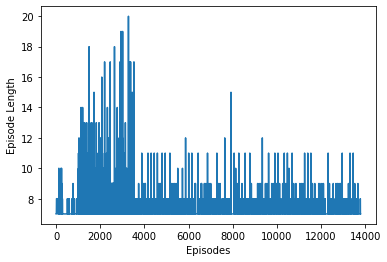

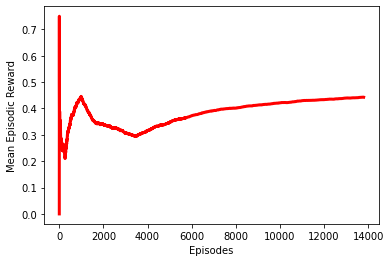

In [44]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# read CSV file while skipping the first row and using the second row as headers
# don't use the first column as index.
df = pd.read_csv(monitor_path+'monitor.csv', skiprows=0, header=1, index_col=None)

print('datatype:', type(df))
print(df.shape)
# data preview
print(df.head())

print(df.columns)

# cumulative sum
print(df['r'].cumsum(axis=0))

df['cumr'] = df['r'].cumsum(axis=0)
df['ep_r'] = df['cumr'] / (df.index + 1)

print(df.head())

total_episodes = df.shape[0]
print('-----------------------')
print('Total Number of episodes: ', total_episodes)
print('Average Episodic Reward:', df['r'].sum(axis=0) / total_episodes)
print('Mean Episode Length:', df['l'].mean())
print('----------------------')
plt.figure(0)
g1 = df['l'].plot()
g1.set_xlabel('Episodes')
g1.set_ylabel('Episode Length')

plt.figure(1)
g2 = df['ep_r'].plot(linewidth=3, color='red')
g2.set_xlabel('Episodes')
g2.set_ylabel('Mean Episodic Reward')
# plt.plot(x = 'Index', y='ep_r', data=df, color='red', linewidth=2)
# plt.show()

### Multi-processing
- It appears the SAC does not support multi-processing
- Currently, I am abandoning this section.

In [8]:
import os
import pybullet as p
import imageio
import gym
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

p.connect(p.DIRECT)   # required for google colab



# Create directories for saving data
root_path = '/content/gdrive/My Drive/Colab/SB3/kuka/'
best_model_path = root_path + 'best_model/kuka_mp/'
eval_path = root_path + 'eval_results/kuka_mp/'
checkpt_path = root_path + 'checkpoints/kuka_mp/'
monitor_path = root_path + 'monitor/kuka_mp/'
tb_log_path = root_path + 'tb_log/'

os.makedirs(best_model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(checkpt_path, exist_ok=True)
os.makedirs(monitor_path, exist_ok=True)


env_id = NormalizeObsvnWrapper
env_kwargs = dict(
    env = KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False)
)
vec_env = make_vec_env(env_id, n_envs=4, monitor_dir=monitor_path, env_kwargs=env_kwargs)


policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(features_dim=64),
    net_arch = dict(qf=[128, 64, 32], pi=[128, 64, 64])
)


model = SAC('CnnPolicy', vec_env, buffer_size=70000, batch_size=256,
            policy_kwargs=policy_kwargs, tensorboard_log=tb_log_path)

# train the model: 50K time steps is adequate
begin = datetime.now()
model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_sac_mp'), 
end = datetime.now()
print('Training time: ', end - begin)


p.disconnect(p.DIRECT)

ValueError: ignored

In [10]:
import os
import pybullet as p
import imageio
import gym
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

p.connect(p.DIRECT)   # required for google colab



# Create directories for saving data
root_path = '/content/gdrive/My Drive/Colab/SB3/kuka/'
best_model_path = root_path + 'best_model/kuka_mp/'
eval_path = root_path + 'eval_results/kuka_mp/'
checkpt_path = root_path + 'checkpoints/kuka_mp/'
monitor_path = root_path + 'monitor/kuka_mp/'
tb_log_path = root_path + 'tb_log/'

os.makedirs(best_model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(checkpt_path, exist_ok=True)
os.makedirs(monitor_path, exist_ok=True)


env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False))

vec_env = DummyVecEnv([lambda: env])

policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(features_dim=64),
    net_arch = dict(qf=[128, 64, 32], pi=[128, 64, 64])
)


model = SAC('CnnPolicy', vec_env, buffer_size=70000, batch_size=256,
            policy_kwargs=policy_kwargs, tensorboard_log=tb_log_path)

# train the model: 50K time steps is adequate
begin = datetime.now()
model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_sac_mp'), 
end = datetime.now()
print('Training time: ', end - begin)


p.disconnect(p.DIRECT)

KeyboardInterrupt: ignored

In [ ]:
import pybullet as p
import imageio
import gym
import numpy as np
import matplotlib.pyplot as plt
from pybullet_envs.bullet.racecarZEDGymEnv import RacecarZEDGymEnv
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

p.connect(p.DIRECT)


#env = RacecarZEDGymEnv(isDiscrete=False, renders=False)
#env = DummyVecEnv([lambda: RacecarZEDGymEnv(isDiscrete=False, renders=False)])
#env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, maxSteps=20,
                           removeHeightHack=False)
env = DummyVecEnv([lambda: KukaDiverseObjectEnv(renders=False, isDiscrete=False, maxSteps=20,
                           removeHeightHack=False)])
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

print('shape of Observation space: ', env.observation_space.shape)
print('shape of Action space: ', env.action_space.shape)
print('Reward Range: ', env.reward_range)
print('Action High value: ', env.action_space.high)
print('Action Low Value: ', env.action_space.low)

policy_kwargs = dict(qf=[128, 128] pi=[64, 64])
feature_extractor_kwargs

cnn_policy = stable_baselines3.sac.CNNPolicy()
# create RL model
model = SAC('CnnPolicy', env, verbose=0, buffer_size=10000)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f'Mean reward before training: {mean_reward:.2f} +/- {std_reward:.2f}')

# Train model
model.learn(total_timesteps=1000)


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f'Mean reward before training: {mean_reward:.2f} +/- {std_reward:.2f}')


# save the model
model.save('racecar_sac')






## PPO

### Single Process Training

In [ ]:
import os
import gym
from stable_baselines3 import PPO
import pybullet as p
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
p.connect(p.DIRECT)

# Create directories for saving data
root_path = '/content/gdrive/My Drive/Colab/SB3/kuka/'
best_model_path = root_path + 'best_model/ppo/'
eval_path = root_path + 'eval_results/ppo/'
checkpt_path = root_path + 'checkpoints/ppo/'
monitor_path = root_path + 'monitor/ppo/'

os.makedirs(best_model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(checkpt_path, exist_ok=True)
os.makedirs(monitor_path, exist_ok=True)


# create the environment
env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False))

env = Monitor(env, monitor_path)

# environment for periodic evaluation
eval_env = NormalizeObsvnWrapper(KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False))
eval_env = Monitor(eval_env, monitor_path)

#callbacks
eval_callback = EvalCallback(eval_env, best_model_save_path=root_path+'best_model/',
                             log_path=root_path+'eval_results/', eval_freq=500,
                             deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=checkpt_path, name_prefix='kuka_ppo_chkpt')
callback_list = CallbackList([checkpoint_callback, eval_callback])


# Custom policy arguments
policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(features_dim=64),
    net_arch = [128, dict(vf=[128, 64, 32], pi=[128, 64, 64])]    # check PPO documentation
)

# Create PPO model 
model = PPO('CnnPolicy', env, n_steps=100000, batch_size=256,
            policy_kwargs=policy_kwargs, tensorboard_log=tb_log_path)

# train the model: 50K time steps is adequate
%time model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_ppo', callback=callback_list)

mean, std = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)
print('Evaluate the model after training: {} +/- {}'.format(mean, std))

p.disconnect(p.DIRECT)


### Multi-process Training

In [18]:
import gym
from stable_baselines3 import PPO
import pybullet as p
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from datetime import datetime
p.connect(p.DIRECT)


# Create directories for saving data
root_path = '/content/gdrive/My Drive/Colab/SB3/kuka/'
best_model_path = root_path + 'best_model/ppo_mp/'
eval_path = root_path + 'eval_results/ppo_mp/'
checkpt_path = root_path + 'checkpoints/ppo_mp/'
monitor_path = root_path + 'monitor/ppo_mp/'
tb_log_path = root_path + 'tb_log/'

os.makedirs(best_model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(checkpt_path, exist_ok=True)
os.makedirs(monitor_path, exist_ok=True)
os.makedirs(tb_log_path, exist_ok=True)

env_id = NormalizeObsvnWrapper
# env_id = KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
#                           removeHeightHack=False)
env_kwargs = dict(
    env = KukaDiverseObjectEnv(maxSteps=20, isDiscrete=False, renders=False,
                          removeHeightHack=False)
)
vec_env = make_vec_env(env_id, n_envs=2, monitor_dir=monitor_path, env_kwargs=env_kwargs)

#eval_vec_env = make_vec_env(env_id, n_envs=1, env_kwargs=env_kwargs)
#callbacks

# eval_callback = EvalCallback(eval_vec_env, best_model_save_path=best_model_path,
#                              log_path=eval_path, eval_freq=1000,
#                              deterministic=True, render=False)
# checkpoint_callback = CheckpointCallback(save_freq=5000, save_path=checkpt_path, name_prefix='kuka_ppo_checkpt')
# callback_list = CallbackList([checkpoint_callback, eval_callback])


policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(features_dim=64),
    net_arch = [128, dict(vf=[128, 64, 32], pi=[128, 64, 64])]    # check PPO documentation
)

model = PPO('CnnPolicy', vec_env, n_steps=2048, batch_size=64,
            policy_kwargs=policy_kwargs, tensorboard_log=tb_log_path)

# train the model: 50K time steps is adequate

begin = datetime.now()
#model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_ppo_mp', callback=eval_callback)
model.learn(total_timesteps=50000, log_interval=4, tb_log_name='kuka_ppo_mp')
end = datetime.now()
print('Training time: ', end-begin)

mean, std = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)
print('Evaluate the model after training: {} +/- {}'.format(mean, std))

p.disconnect(p.DIRECT)


KeyboardInterrupt: ignored

In [ ]:

env_id = KukaDiverseObjectEnv

env_kwargs = dict(
    maxSteps=20, 
    isDiscrete=False, 
    renders=False,
    removeHeightHack=False
)

vec_env = make_vec_env(env_id, n_envs=2, monitor_dir=monitor_path, env_kwargs=env_kwargs)


# Trying VSCODE

In [1]:
!pip install colabcode > /dev/null 2>&1

     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 747kB 20.9MB/s 
     |████████████████████████████████| 8.3MB 24.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 399kB 38.1MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 430kB 49.1MB/s 
     |████████████████████████████████| 122kB 48.4MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19262 sha256=451412d90e71704f3c0a435a9a9df29df4df8833e427f7df22dc30fd74457c98
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6

In [2]:
from colabcode import ColabCode
#ColabCode(port=10000, password="password123")
ColabCode()

Code Server can be accessed on: NgrokTunnel: "https://6bb3c8cdb430.ngrok.io" -> "http://localhost:10000"
[2021-07-10T14:22:27.133Z] info  code-server 3.10.2 387b12ef4ca404ffd39d84834e1f0776e9e3c005
[2021-07-10T14:22:27.135Z] info  Using user-data-dir ~/.local/share/code-server
[2021-07-10T14:22:27.148Z] info  Using config file ~/.config/code-server/config.yaml
[2021-07-10T14:22:27.148Z] info  HTTP server listening on http://127.0.0.1:10000 
[2021-07-10T14:22:27.148Z] info    - Authentication is disabled 
[2021-07-10T14:22:27.148Z] info    - Not serving HTTPS 


KeyboardInterrupt: ignored